In [481]:
# all of the imports
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

% matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
cleaned_df = pd.read_pickle('merged_df.pkl')
cleaned_df.head()

,backers_count,country,id,name,spotlight,staff_pick,state,static_usd_rate,usd_pledged,gdp_ppp_pc,blurb_word_count,blurb_letter_count_average,hype_duration_days,campaign_duration_days,usd_goal,slug_word_count,slug_letter_count_average,category_name
0,80,US,62545913,"""How We've Changed Jesus"" - Neal Samudre's Deb...",True,False,successful,1.000000,3651.000000,59500,21,5.619048,2.80,7.88,3500.000000,8,5.875000,nonfiction
1,31,GB,2031730466,Your Client Vision (Book) - How to sell withou...,True,False,successful,1.247352,338.032525,43600,24,5.125000,0.88,29.15,218.286686,9,5.555556,nonfiction
2,357,US,55673621,"500 Old Christian Books, REPUBLISHED!",True,False,successful,1.000000,22152.000000,59500,23,5.565217,21.79,29.01,10000.000000,5,7.000000,nonfiction
3,74,CA,614137516,The Longest Lie I Ever Told,True,False,successful,0.752649,2709.535536,48100,28,4.464286,3.48,30.04,2257.946280,6,4.500000,nonfiction
4,12,DE,1164271753,Spurenlesen – Zur Philosophie der Human-Animal...,True,False,successful,1.111358,1200.266726,50200,15,8.066667,6.92,30.00,1111.358080,7,7.142857,nonfiction


In [9]:
# test the creation of dummy variables
cols_to_transform = [ 'country', 'spotlight', 'staff_pick', 'state', 'category_name']
print(pd.get_dummies(cleaned_df, columns = cols_to_transform).columns.shape)
pd.get_dummies(cleaned_df, columns = cols_to_transform, drop_first=True).columns.shape


(81,)


(76,)

In [12]:
cleaned_with_dummies = pd.get_dummies(cleaned_df, columns = cols_to_transform, drop_first=True)
cleaned_with_dummies.head()

,backers_count,id,name,static_usd_rate,usd_pledged,gdp_ppp_pc,blurb_word_count,blurb_letter_count_average,hype_duration_days,campaign_duration_days,...,category_name_punk,category_name_science_fiction,category_name_sculpture,category_name_software,category_name_tabletop_games,category_name_theater,category_name_video_games,category_name_weaving,category_name_web,category_name_workshops
0,80,62545913,"""How We've Changed Jesus"" - Neal Samudre's Deb...",1.000000,3651.000000,59500,21,5.619048,2.80,7.88,...,0,0,0,0,0,0,0,0,0,0
1,31,2031730466,Your Client Vision (Book) - How to sell withou...,1.247352,338.032525,43600,24,5.125000,0.88,29.15,...,0,0,0,0,0,0,0,0,0,0
2,357,55673621,"500 Old Christian Books, REPUBLISHED!",1.000000,22152.000000,59500,23,5.565217,21.79,29.01,...,0,0,0,0,0,0,0,0,0,0
3,74,614137516,The Longest Lie I Ever Told,0.752649,2709.535536,48100,28,4.464286,3.48,30.04,...,0,0,0,0,0,0,0,0,0,0
4,12,1164271753,Spurenlesen – Zur Philosophie der Human-Animal...,1.111358,1200.266726,50200,15,8.066667,6.92,30.00,...,0,0,0,0,0,0,0,0,0,0


In [13]:
cleaned_with_dummies.columns

Index(['backers_count', 'id', 'name', 'static_usd_rate', 'usd_pledged',
       'gdp_ppp_pc', 'blurb_word_count', 'blurb_letter_count_average',
       'hype_duration_days', 'campaign_duration_days', 'usd_goal',
       'slug_word_count', 'slug_letter_count_average', 'country_AU',
       'country_BE', 'country_CA', 'country_CH', 'country_DE', 'country_DK',
       'country_ES', 'country_FR', 'country_GB', 'country_HK', 'country_IE',
       'country_IT', 'country_LU', 'country_MX', 'country_NL', 'country_NO',
       'country_NZ', 'country_SE', 'country_SG', 'country_US',
       'spotlight_True', 'staff_pick_True', 'state_successful',
       'category_name_art', 'category_name_calendars',
       'category_name_civic_design', 'category_name_comedy',
       'category_name_comic_books', 'category_name_conceptual_art',
       'category_name_design', 'category_name_digital_art',
       'category_name_electronic_music', 'category_name_experimental',
       'category_name_family', 'category_name_fa

# First Step 
## test train split

In [91]:
cleaned_with_dummies.drop(columns=['id', 'name', 'static_usd_rate', 'usd_pledged']).columns

Index(['backers_count', 'gdp_ppp_pc', 'blurb_word_count',
       'blurb_letter_count_average', 'hype_duration_days',
       'campaign_duration_days', 'usd_goal', 'slug_word_count',
       'slug_letter_count_average', 'country_AU', 'country_BE', 'country_CA',
       'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR',
       'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_LU',
       'country_MX', 'country_NL', 'country_NO', 'country_NZ', 'country_SE',
       'country_SG', 'country_US', 'spotlight_True', 'staff_pick_True',
       'state_successful', 'category_name_art', 'category_name_calendars',
       'category_name_civic_design', 'category_name_comedy',
       'category_name_comic_books', 'category_name_conceptual_art',
       'category_name_design', 'category_name_digital_art',
       'category_name_electronic_music', 'category_name_experimental',
       'category_name_family', 'category_name_farms',
       'category_name_festivals', 'category_name_

In [597]:
X = cleaned_with_dummies.drop(columns=['id', 'name', 'static_usd_rate', 'usd_pledged', 'spotlight_True'])
y = cleaned_with_dummies['usd_pledged']

lr = LinearRegression()

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Fit the model against the training data
lr.fit(x_train, y_train)
# Evaluate the model against the testing data
lr.score(x_test, y_test)

0.778146252009089

In [598]:
lr.score(X, y)

0.7120818918628886

In [599]:
#adjusted r squared
print(1 - (1-lr.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))

0.7066277334643467


In [600]:
np.sqrt(mean_squared_error(y_test, lr.predict(x_test)))

18367.836925118972

In [601]:
# look at the betas 
pprint.pprint(sorted(dict(zip(list(X.columns),lr.coef_)).items(), key=lambda kv: kv[1]))

[('category_name_video_games', -218225.22977214397),
 ('country_HK', -74850.42439238339),
 ('country_MX', -59802.77646380499),
 ('country_ES', -50822.19859964431),
 ('country_IT', -49739.21600649218),
 ('country_NZ', -45770.755667907026),
 ('country_GB', -43258.457798907846),
 ('country_BE', -42247.53497690066),
 ('country_FR', -40765.745164549444),
 ('country_CA', -40492.14861428341),
 ('category_name_civic_design', -39695.61857427182),
 ('country_NL', -38963.53697960342),
 ('country_DK', -38818.067173804),
 ('country_AU', -37299.78903002173),
 ('country_DE', -35884.09572530419),
 ('country_SE', -35479.2260655107),
 ('country_US', -32702.708834922643),
 ('country_IE', -25833.077870304063),
 ('country_NO', -25574.87407841331),
 ('country_SG', -21721.573090234528),
 ('country_LU', -7442.686441001598),
 ('slug_letter_count_average', -101.35135516483842),
 ('blurb_word_count', -32.41187704463477),
 ('gdp_ppp_pc', -0.5908179379167507),
 ('hype_duration_days', -0.5264217428423308),
 ('categ

# Cross Validation

In [190]:
from sklearn.cross_validation import cross_val_score

In [191]:
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

[5.69622619e+07 1.83356307e+08 9.30498209e+07 3.47056692e+08
 7.77379571e+07 8.24928431e+07 5.39729568e+08 9.02407138e+08
 5.12285062e+08 9.03897666e+08]


# Automatic Cross Validation

In [192]:
from sklearn.linear_model import RidgeCV

In [193]:
rcv = RidgeCV(alphas=np.linspace(1e-6,1,100),cv=10)

In [194]:
rcv.fit(X, y)
rcv.score(x_test, y_test)

0.7019334457955748

In [288]:
rcv_y = rcv.predict(X)
np.sqrt(mean_squared_error(y, rcv_y))

18370.95689351976

# Scaled Data

In [195]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.linear_model import Ridge, Lasso

# X = cleaned_with_dummies.drop(columns=['id', 'name', 'static_usd_rate', 'usd_pledged'])
# y = cleaned_with_dummies['usd_pledged']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [198]:
from sklearn.preprocessing import StandardScaler

ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(x_train)

### Lasso

In [199]:
model = Lasso()
parameters = {'alpha': [1e-5,1e-3,1e-1,1,1e2, 1e3], 'fit_intercept': [True,False]}
grid = GridSearchCV(model,parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.001, 0.1, 1, 100.0, 1000.0], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [200]:
def print_test_scores(grid):
    for ix in range(5):
        key = "split{}_test_score".format(ix)
        print(key,grid.cv_results_[key])
        
print_test_scores(grid)

split0_test_score [ -6614.19181769 -60963.68697311  -6614.18761994 -60963.42133912
  -6613.76906687 -60936.87415973  -6609.96083291 -60695.97166077
  -6307.41591725 -36924.10332644  -5836.05209156 -12537.55794974]
split1_test_score [ -6393.19762249 -60896.84190178  -6393.1499569  -60850.98567975
  -6388.38396636 -60832.51888474  -6375.87946673 -60663.38620026
  -6192.68854327 -43734.99298028  -5999.71811718 -12890.22769808]
split2_test_score [ -6985.96282012 -62715.07491709  -6985.95865461 -62714.80913255
  -6985.4475329  -62688.13895737  -6981.05217027 -62446.10645564
  -6642.39206995 -38307.09666145  -5637.52445872 -12556.91127803]
split3_test_score [ -5318.91336576 -60394.55122232  -5318.91124607 -60394.27442606
  -5318.70804409 -60366.62941841  -5316.85340572 -60116.09440361
  -5243.19008267 -36263.3133356   -4931.82256877 -11754.49955163]
split4_test_score [ -6321.51902497 -13422.96965279  -6321.5165035  -13422.96868944
  -6321.26435605 -13422.87235394  -6318.73240252 -13421.97409

In [202]:
X_test_scaled = ssX.transform(x_test)
best_lasso = grid.best_estimator_
lasso_pred = best_lasso.predict(X_test_scaled)
for true,pred in zip(y_test[:20], lasso_pred[:20]):
    resid = true - pred
    print("pred, resid:", str(pred) + ", "+ str(resid))

pred, resid: 9405.074663614974, -1020.064663614974
pred, resid: 11688.557511411542, 8439.442488588458
pred, resid: 1149.4059061966145, -1148.4059061966145
pred, resid: 5306.515706031392, -1123.5157060313923
pred, resid: 2203.3210667181083, -1173.3210667181083
pred, resid: 4955.210652524228, -1881.210652524228
pred, resid: 6770.286762311243, -1999.2867623112434
pred, resid: 1734.9143287085553, -1347.9143287085553
pred, resid: 1090.8550639454206, -1090.8550639454206
pred, resid: 5072.312337026616, -226.31233702661575
pred, resid: 17656.822247387987, -11789.172709637987
pred, resid: 5130.86317927781, 2361.1368207221904
pred, resid: 3315.7870694907942, 586.2129305092058
pred, resid: 1149.4059061966145, -1139.4059061966145
pred, resid: 9697.828874870946, 2402.1711251290544
pred, resid: 10693.193193141244, 15491.806806858756
pred, resid: 21232.34479835617, -14022.224798356172
pred, resid: 1325.058432950198, -1165.058432950198
pred, resid: 2203.3210667181083, -1073.3210667181083
pred, resid: 

In [203]:
print(grid.best_params_, grid.best_score_)

{'alpha': 1000.0, 'fit_intercept': True} -5681.214735979072


### Ridge

In [280]:
model = Ridge()
parameters = {'alpha': np.linspace(1e-6,1e2,50)}
grid = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)

In [281]:
parameters['alpha']

array([1.00000000e-06, 2.04081731e+00, 4.08163361e+00, 6.12244992e+00,
       8.16326622e+00, 1.02040825e+01, 1.22448988e+01, 1.42857151e+01,
       1.63265314e+01, 1.83673478e+01, 2.04081641e+01, 2.24489804e+01,
       2.44897967e+01, 2.65306130e+01, 2.85714293e+01, 3.06122456e+01,
       3.26530619e+01, 3.46938782e+01, 3.67346945e+01, 3.87755108e+01,
       4.08163271e+01, 4.28571434e+01, 4.48979597e+01, 4.69387760e+01,
       4.89795923e+01, 5.10204087e+01, 5.30612250e+01, 5.51020413e+01,
       5.71428576e+01, 5.91836739e+01, 6.12244902e+01, 6.32653065e+01,
       6.53061228e+01, 6.73469391e+01, 6.93877554e+01, 7.14285717e+01,
       7.34693880e+01, 7.55102043e+01, 7.75510206e+01, 7.95918369e+01,
       8.16326532e+01, 8.36734696e+01, 8.57142859e+01, 8.77551022e+01,
       8.97959185e+01, 9.18367348e+01, 9.38775511e+01, 9.59183674e+01,
       9.79591837e+01, 1.00000000e+02])

In [282]:
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-06, 2.04082e+00, 4.08163e+00, 6.12245e+00, 8.16327e+00,
       1.02041e+01, 1.22449e+01, 1.42857e+01, 1.63265e+01, 1.83673e+01,
       2.04082e+01, 2.24490e+01, 2.44898e+01, 2.65306e+01, 2.85714e+01,
       3.06122e+01, 3.26531e+01, 3.46939e+01, 3.67347e+01, 3.87... 8.77551e+01, 8.97959e+01,
       9.18367e+01, 9.38776e+01, 9.59184e+01, 9.79592e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [399]:
best_ridge = grid.best_estimator_
ridge_pred = best_ridge.predict(X_test_scaled)
for true,pred in zip(y_test[:20], ridge_pred[:20]):
    resid = true - pred
    print("pred, resid:", str(pred) + ", "+ str(resid))

pred, resid: -1075.6451521277686, 16490.64515212777
pred, resid: 5812.162639273213, 79940.82736072679
pred, resid: 6936.178201616094, -6936.178201616094
pred, resid: 3046.66393204833, -1431.66393204833
pred, resid: 8342.29975439385, 2558.700245606149
pred, resid: -840.283560023523, 18177.29356002352
pred, resid: 5282.599057038661, -3702.599057038661
pred, resid: 2281.7387577095324, 9605.261242290468
pred, resid: 7812.736172159299, -4951.617393119299
pred, resid: 6047.524231377459, 7328.475768622541
pred, resid: 2987.823534022268, -2971.823534022268
pred, resid: 5164.918260986539, -3016.4882609865394
pred, resid: 3870.4295044131886, 6637.570495586811
pred, resid: 45250.42846623549, 76035.57153376451
pred, resid: 16821.3650699944, -15008.6005855544
pred, resid: 8871.863336628405, -7858.863336628405
pred, resid: 8877.911336476118, -6877.911336476118
pred, resid: 79325.0669231727, -53817.54876762269
pred, resid: 3693.908310335005, -3380.908310335005
pred, resid: 15179.503852566322, 3829.49

In [378]:
print(grid.best_params_, grid.best_score_)

{'alpha': 4.081633612244898} -5779.437703305121


Now let's compare the two models

In [285]:
from sklearn.metrics import mean_squared_error

print("Lasso: ", np.sqrt(mean_squared_error(y_test, lasso_pred)))
print("Ridge: ", np.sqrt(mean_squared_error(y_test, ridge_pred)))

Lasso:  47860.266915571454
Ridge:  35864.83313149509


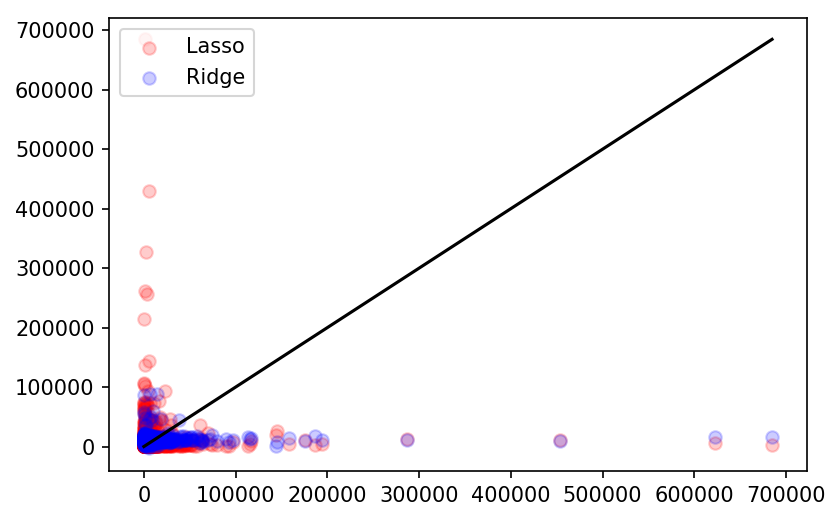

In [286]:
plt.figure(dpi=150)
plt.scatter(y_test, lasso_pred, label="Lasso", c='r', alpha=0.2)
plt.scatter(y_test, ridge_pred, label="Ridge", c='b', alpha=0.2)
plt.plot([min(y_test), max(y_test)],[min(y_test), max(y_test)],'k', zorder=10)
plt.legend(loc="upper left");

In [602]:
# Let's start with filtering features using p-value:

est=LinearRegression()
from sklearn import feature_selection as f_select

sig_columns=[]
pvals=[] # will be the list of all significant columns' p-values

for feature in X.columns:
    #get pval on feature by feature basis
    pval=f_select.f_regression(X[[feature]],y) # univariate regression for feature selection ; gets f-value and p-value scores
    print(pval)
    if pval[1][0]<.01: 
        sig_columns.append(feature)
        pvals.append(pval[1][0])
        
X_trans=X[sig_columns]

cross_val_score(est,X_trans,y,cv=5,scoring='r2').mean() 
# returns array of scores of the estimator for each run of the cross validation

(array([8017.25354072]), array([0.]))
(array([2.24358063]), array([0.13425264]))
(array([1.79304414]), array([0.18063542]))
(array([7.84592286]), array([0.00511918]))
(array([9.43069954]), array([0.00214885]))
(array([4.05979621]), array([0.04398577]))
(array([7.3955252]), array([0.00656822]))
(array([6.11298071]), array([0.01346252]))
(array([0.94630034]), array([0.33072443]))
(array([0.07404297]), array([0.7855534]))
(array([0.18986785]), array([0.66305126]))
(array([0.75848457]), array([0.38385794]))
(array([2.49443884]), array([0.11433193]))
(array([0.0032814]), array([0.95432232]))
(array([0.23533419]), array([0.62762434]))
(array([0.99833434]), array([0.3177772]))
(array([0.03863621]), array([0.84418159]))
(array([1.39976311]), array([0.2368369]))
(array([1.60369902]), array([0.20545705]))
(array([6.37212315e-05]), array([0.99363132]))
(array([0.60612847]), array([0.43629749]))
(array([0.23334583]), array([0.62908167]))
(array([0.53884924]), array([0.46295511]))
(array([1.9353943

0.5961372254200166

In [603]:
pprint.pprint(sig_columns)

['backers_count',
 'blurb_letter_count_average',
 'hype_duration_days',
 'usd_goal',
 'staff_pick_True',
 'state_successful',
 'category_name_civic_design',
 'category_name_gadgets',
 'category_name_nonfiction',
 'category_name_product_design',
 'category_name_tabletop_games',
 'category_name_video_games']


In [604]:
# how many significant columns?
len(sig_columns)

12

In [605]:
import pprint
pprint.pprint(dict(zip(sig_columns, pvals)))

{'backers_count': 0.0,
 'blurb_letter_count_average': 0.005119184561516431,
 'category_name_civic_design': 2.4602244248752387e-05,
 'category_name_gadgets': 4.009959994170266e-33,
 'category_name_nonfiction': 0.0009950876717096048,
 'category_name_product_design': 1.4145432083528486e-17,
 'category_name_tabletop_games': 9.852946695979906e-13,
 'category_name_video_games': 6.130284059482579e-22,
 'hype_duration_days': 0.002148846917335274,
 'staff_pick_True': 2.5842718577902833e-36,
 'state_successful': 1.3626500753501463e-13,
 'usd_goal': 0.00656822034652216}


In [606]:
columns = sig_columns[:]
lr = LinearRegression()
lr.fit(X[columns], y)
lr.score(X[columns], y)

0.7073507662985167

In [607]:
pprint.pprint(sorted(dict(zip(columns,list(lr.coef_))).items(), key=lambda kv: kv[1]))

[('category_name_video_games', -181628.56166808368),
 ('category_name_civic_design', -43269.21143844214),
 ('category_name_nonfiction', -1189.7914078034653),
 ('staff_pick_True', -101.58366482842945),
 ('hype_duration_days', -0.7583646680638313),
 ('usd_goal', 0.003520795096841078),
 ('backers_count', 59.46829183854222),
 ('blurb_letter_count_average', 455.40215631114313),
 ('state_successful', 3705.67922977007),
 ('category_name_gadgets', 14175.785557825671),
 ('category_name_product_design', 15347.321299175237),
 ('category_name_tabletop_games', 22910.17911345476)]


In [608]:
#adjusted r-squared value
print(1 - (1-lr.score(X[columns], y))*(len(y)-1)/(len(y)-X[columns].shape[1]-1))

0.7064283100851156


In [451]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [609]:
sqrt(mean_squared_error(y, lr.predict(X[columns])))

18513.201569344055

In [466]:
cleaned_with_dummies['usd_pledged'].describe()

count      3820.000000
mean      10963.156858
std       34226.673055
min           0.000000
25%        1230.000000
50%        3933.726293
75%        9185.500000
max      684755.900000
Name: usd_pledged, dtype: float64

Because the RMSE is higher than the mean of the USD pledged (dependent variable), another model must be tested to see if it improves the results. 

In [467]:
X = cleaned_with_dummies[columns]
y = cleaned_with_dummies['usd_pledged']

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(x_train)
X_test_scaled = ssX.transform(x_test)
model = Ridge()
parameters = {'alpha': np.linspace(1e-6,1e2,50)}
grid = GridSearchCV(model, parameters, cv=10, scoring='neg_mean_absolute_error', n_jobs=1)
grid.fit(X_train_scaled, y_train)
best_ridge = grid.best_estimator_
ridge_pred = best_ridge.predict(X_test_scaled)
for true,pred in zip(y_test[:20], ridge_pred[:20]):
    resid = true - pred
    print("pred, resid:", str(pred) + ", "+ str(resid))
print(grid.best_params_, grid.best_score_)
print("Ridge: ", np.sqrt(mean_squared_error(y_test, ridge_pred)))

pred, resid: -1392.768183356211, 1392.768183356211
pred, resid: 6280.4310138821975, -4669.012124222198
pred, resid: 6886.5907335156935, -3132.5907335156935
pred, resid: 4149.3693508383885, 1100.6306491616115
pred, resid: 31674.460673709953, 5090.539326290047
pred, resid: 2862.501491509437, -1862.501491509437
pred, resid: 5425.158536012557, -97.04270233255738
pred, resid: 18534.13266274033, -5524.132662740329
pred, resid: 10620.30846624051, -6789.282456000511
pred, resid: 21585.71869383761, -9548.71869383761
pred, resid: 4038.0285439303498, 641.4768336696507
pred, resid: 44352.23790967759, -33923.23790967759
pred, resid: 13348.880242222705, -7960.880242222705
pred, resid: 6071.301116992504, 14712.348883007497
pred, resid: -1305.7009109770152, 1410.7009109770152
pred, resid: 5739.528537734991, -2839.693045964991
pred, resid: 10131.722751507026, -5190.722751507026
pred, resid: 10213.887696650798, -3532.887696650798
pred, resid: -1338.145489597302, 1348.145489597302
pred, resid: 106640.871

In [508]:
degree = 2
alpha = [1e2]
poly = make_pipeline(PolynomialFeatures(degree), LassoCV(alphas=alpha, cv=5))
poly.fit(X,y)
s = poly.score(X,y)
r = np.sqrt(mean_squared_error(y, poly.predict(X)))

print('R squared', s, 'RMSE:', r)

R squared 0.8504638152186104 RMSE: 13233.69076246659


In [507]:
X_scaled = ssX.fit_transform(X)
poly_features = PolynomialFeatures(2)
poly_ft = poly_features.fit_transform(X_scaled)
poly_lasso = LassoCV(alphas=alpha, cv=5)
poly_lasso.fit(poly_ft, y)
poly_lasso_coef = poly_lasso.coef_
poly_s = poly_lasso.score(poly_ft, y)
poly_r = np.sqrt(mean_squared_error(y, poly_lasso.predict(poly_ft)))

print('R squared', poly_s, 'RMSE:', poly_r)
pprint.pprint(sorted(dict(zip(poly_features.get_feature_names(columns),poly_lasso_coef)).items(), key=lambda kv: kv[1]))

R squared 0.848419976087495 RMSE: 13323.821926578354
[('spotlight_True^2', -2148.0139175357326),
 ('backers_count staff_pick_True', -2112.806745665562),
 ('hype_duration_days category_name_tabletop_games', -2103.8008791621523),
 ('blurb_letter_count_average category_name_gadgets', -1381.0171022811933),
 ('staff_pick_True category_name_tabletop_games', -864.0204007713961),
 ('hype_duration_days staff_pick_True', -614.2926167559451),
 ('blurb_letter_count_average category_name_video_games', -521.2572376008756),
 ('blurb_letter_count_average spotlight_True', -330.81757037451723),
 ('state_successful^2', -312.0465536442283),
 ('backers_count^2', -304.19424377242626),
 ('staff_pick_True category_name_nonfiction', -260.5373799179956),
 ('category_name_tabletop_games^2', -138.62038007050248),
 ('blurb_letter_count_average hype_duration_days', -116.0074672611904),
 ('category_name_video_games^2', -96.3202355632945),
 ('hype_duration_days^2', -35.983817128694675),
 ('blurb_letter_count_average 

Although the RMSE is lower by 5,000 dollars, the betas (coefficients) are harder to interpret. Thus, the better model is the linear regression. Below are some plots that show some correlation between the independent variables and dependent variables.

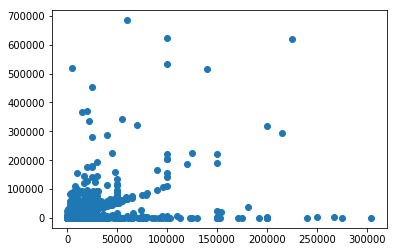

In [583]:
plt.scatter(cleaned_df.sort_values('usd_goal')['usd_goal'][:-20],
           cleaned_df.sort_values('usd_goal')['usd_pledged'][:-20])

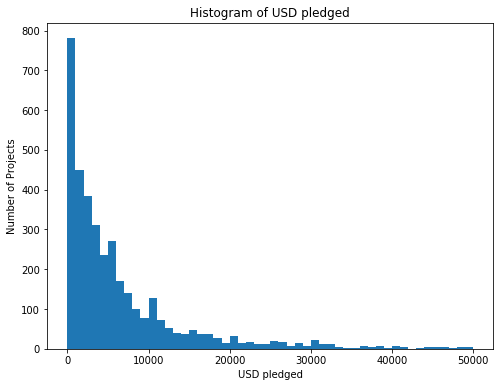

In [569]:
plt.figure(figsize=(8,6))
plt.hist(cleaned_with_dummies['usd_pledged'], range=(0,5e4),bins=50)
plt.xlabel('USD pledged')
plt.ylabel('Number of Projects')
plt.title('Histogram of USD pledged')
plt.savefig('histogram_usd_pledged.jpg', dpi = 300)

In [552]:
cleaned_with_dummies['usd_pledged'].skew()

11.008248131578254

In [567]:
cleaned_with_dummies['usd_pledged'].quantile(.96333)

50000.46092161817

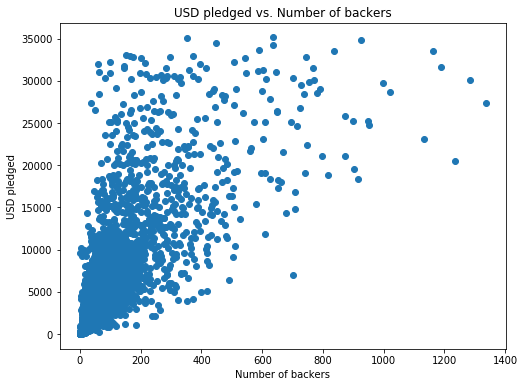

In [587]:
plt.figure(figsize=(8,6))
plt.scatter(cleaned_df.sort_values('usd_pledged')['backers_count'][:-200],
           cleaned_df.sort_values('usd_pledged')['usd_pledged'][:-200])
plt.xlabel('Number of backers')
plt.ylabel('USD pledged')
plt.title('USD pledged vs. Number of backers')
plt.savefig('backers_usd_pledged.jpg', dpi = 300)